<a href="https://colab.research.google.com/github/nigaga/Classification-satellite-image-deep-learning/blob/main/SAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio geopandas scikit-learn tensorflow matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 35.0 MB/s eta 0:00:00


# **Import data**

In [ ]:
# Essential and common packages
import os
import glob

# Read and visualize the raster data
import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

# Tensorflow for building the resnet50 model
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

# Sklearn for confusion matrix
import itertools
from sklearn.metrics import confusion_matrix


from google.colab import drive
drive.mount('/content/drive')


%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!pip install gdown

import gdown


file_id = '1WKFN-dLiC3g7voqb6eDHUEsZo0z9iS-j'

url = f'https://drive.google.com/uc?id={file_id}'


output = '/content/EuroSAT.zip'
gdown.download(url, output, quiet=False)

import zipfile
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

dataset_dir = '/content/dataset/2750'

import os
os.listdir(dataset_dir)




Downloading...
From (original): https://drive.google.com/uc?id=1WKFN-dLiC3g7voqb6eDHUEsZo0z9iS-j
From (redirected): https://drive.google.com/uc?id=1WKFN-dLiC3g7voqb6eDHUEsZo0z9iS-j&confirm=t&uuid=9195b4b9-4dcc-4963-a10c-bc15c6927998
To: /content/EuroSAT.zip
100%|██████████| 94.3M/94.3M [00:01<00:00, 80.3MB/s]


['Residential',
 'PermanentCrop',
 'Pasture',
 'River',
 'AnnualCrop',
 'Industrial',
 'SeaLake',
 'Highway',
 'HerbaceousVegetation',
 'Forest']

# **Training Data**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


batch_size = 32
img_height = 64
img_width = 64
validation_split = 0.2
rescale = 1.0/255


train_datagen = ImageDataGenerator(
    rescale=rescale,
    validation_split=validation_split
)


train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)


val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


# **Visualization Training Images**

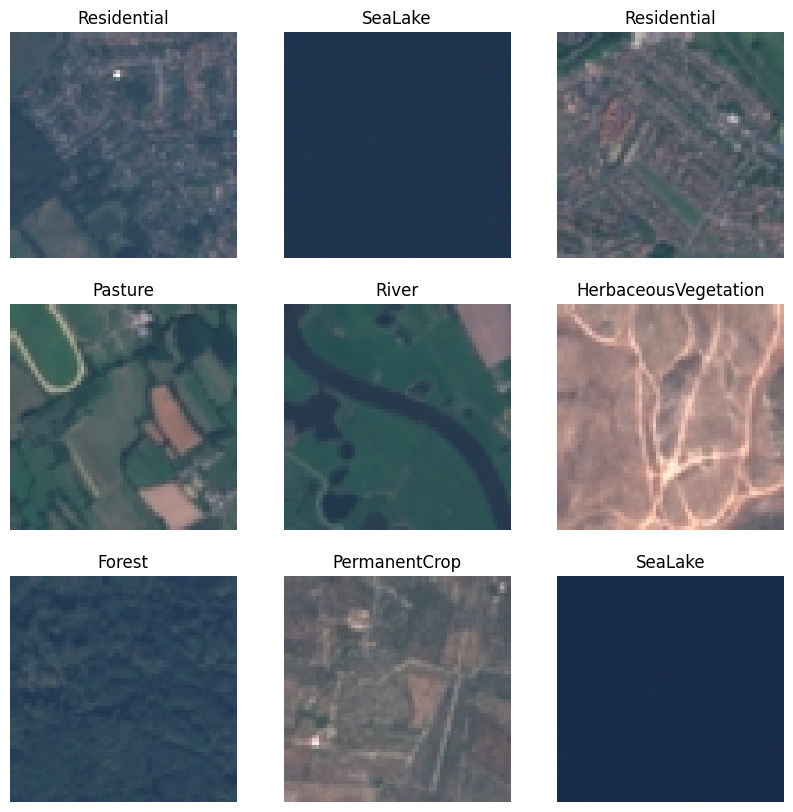

In [ ]:
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))

images, labels = next(train_generator)

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.show()

# **Building Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,458,186 (9.38 MB)

 Trainable params: 2,458,186 (9.38 MB)

 Non-trainable params: 0 (0.00 B)

# Training the CNN Model

In [ ]:
epochs = 15

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)


Epoch 1/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 181s 268ms/step - accuracy: 0.7492 - loss: 0.6959 - val_accuracy: 0.7531 - val_loss: 0.6902
Epoch 2/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 184s 273ms/step - accuracy: 0.7865 - loss: 0.6047 - val_accuracy: 0.8274 - val_loss: 0.4824
Epoch 3/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 183s 271ms/step - accuracy: 0.8170 - loss: 0.5183 - val_accuracy: 0.7865 - val_loss: 0.5977
Epoch 4/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 178s 263ms/step - accuracy: 0.8331 - loss: 0.4615 - val_accuracy: 0.8404 - val_loss: 0.4375
Epoch 5/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 174s 258ms/step - accuracy: 0.8588 - loss: 0.3968 - val_accuracy: 0.8483 - val_loss: 0.4338
Epoch 6/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 174s 257ms/step - accuracy: 0.8768 - loss: 0.3497 - val_accuracy: 0.8635 - val_loss: 0.4023
Epoch 7/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 174s 258ms/step - accuracy: 0.8962 - loss: 0.2959 - val_accuracy: 0.8650 - val_loss: 0.4076
Epoch 8/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 185s 274ms/step - accuracy: 0.9076 -

# **analyzing results and visualization**

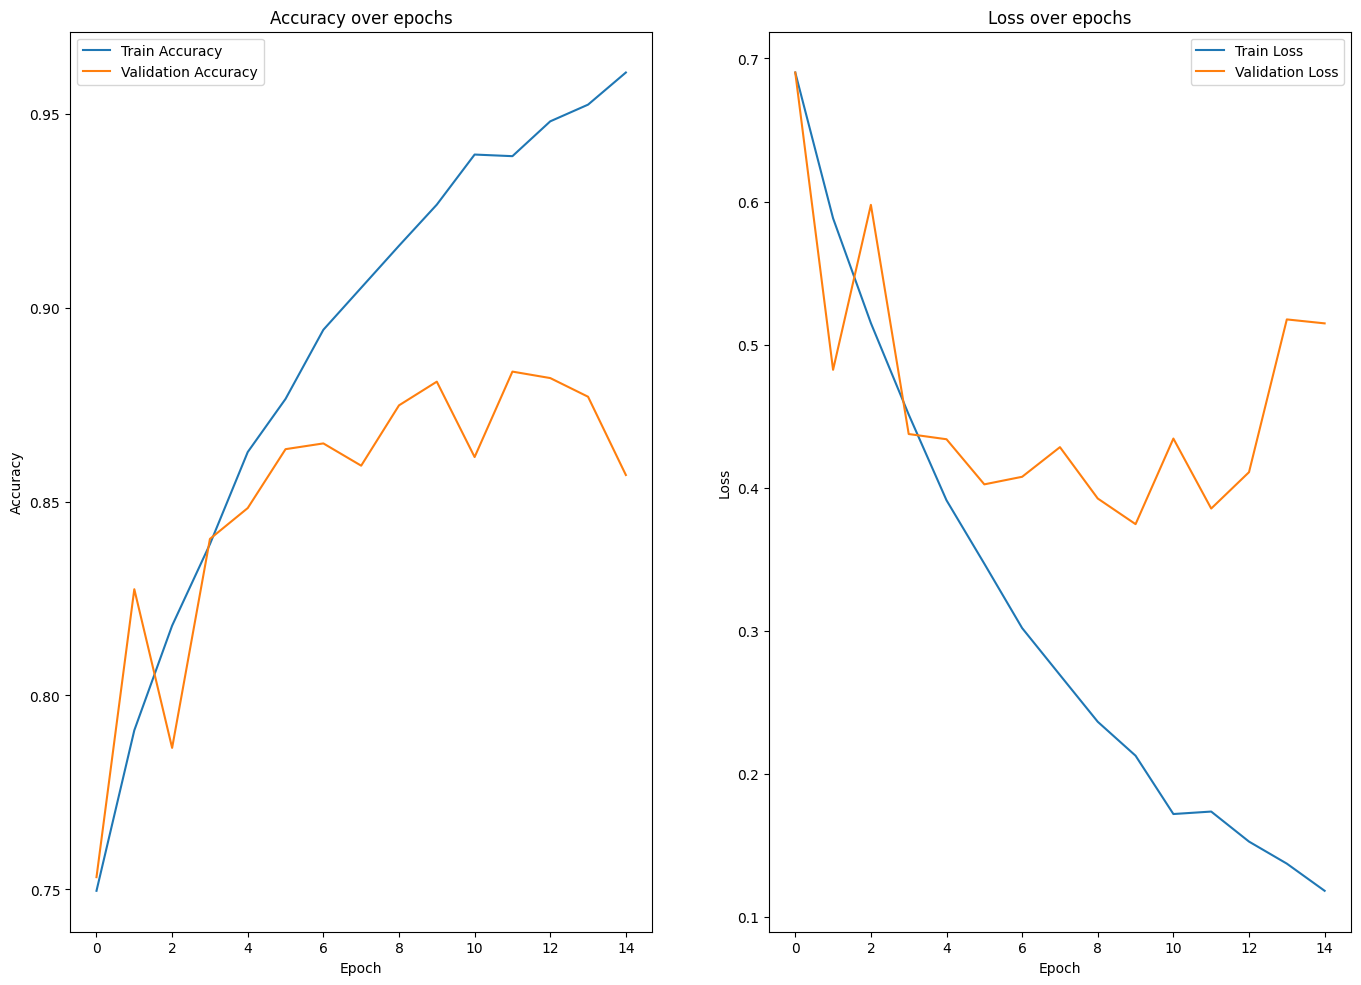

In [ ]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy over epochs')
ax1.legend(loc='upper left')

# Plot loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Loss over epochs')
ax2.legend(loc='upper right')

plt.show()


# **Confusion matrix**

169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.8248 - loss: 0.6265
Validation Accuracy: 85.69%
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step


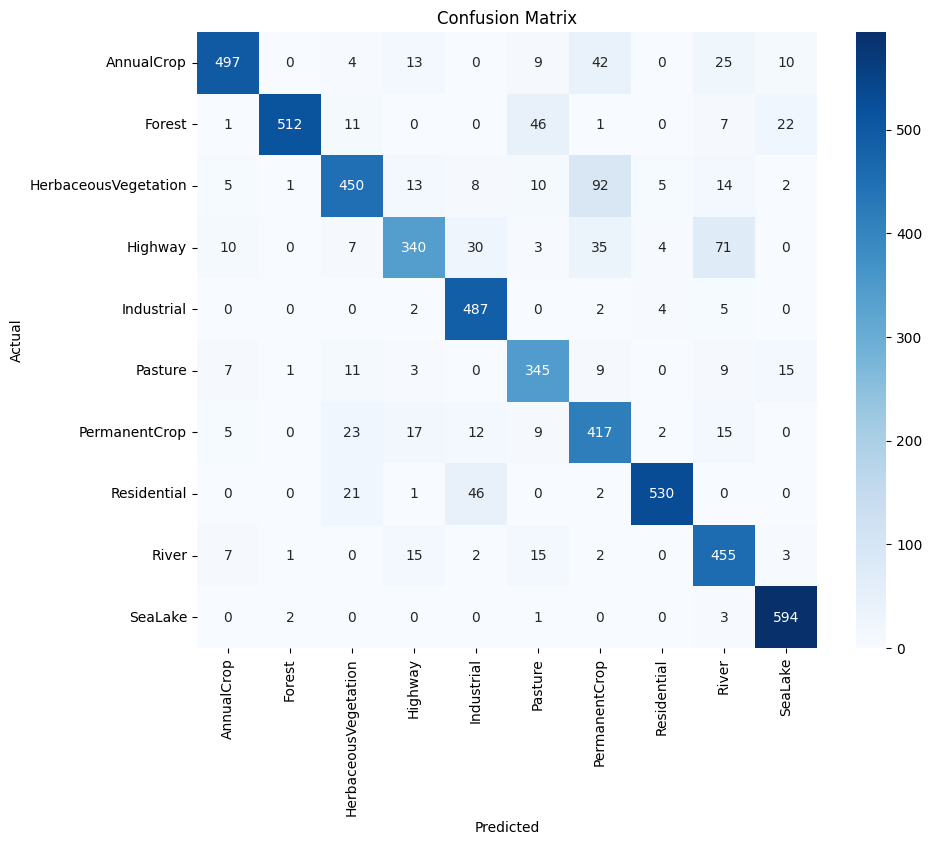

In [ ]:

from sklearn.metrics import confusion_matrix


loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy*100:.2f}%")


y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# **Save Model**

In [ ]:

model.save('satellite_image_classifier.h5')
print("Model saved successfully.")


Model saved successfully.
